<p><img alt="udeA logo" height="150px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" align="left" hspace="50px" vspace="0px" style="width:107px;height:152px;"></p>
<h1><font color='#FFFFFFF'> <center>
Proyecto 3: Filtros</center></font></h1>
<h2><font color='#FFFFFFF'> <center>
Proyecto 2024-02 </center></font></h2>
<h3><font color='#FFFFFFF'> <center>María J. Ostos - Cristian Florez - Juan A. Sañudo</center></font></h3>
<h3><font color='#FFFFFFF'> <center>
2024 </center></font></h3>
<font  face="Courier New" size="3">
<p1><center> </center></p1>

1. Del artículo: https://www.nature.com/articles/s41598-020-59821-7

Consultar y explicar los dos métodos de reducción de ruido usados en el artículo: Robust LOESS y Non Local Means (10%), mostrar cómo se podrían implementar en Python (5%)

LOESS (Locally Weighted Scatterplot Smoothing): Es un método de suavizado no paramétrico que ajusta localmente una función a los datos. En esencia, LOESS crea un modelo de regresión lineal ponderada para cada punto de datos, utilizando solo los puntos cercanos para estimar el valor en ese punto. Esto permite adaptarse a patrones locales en los datos, incluso si la relación global no es lineal.
es importante porque:
-Adaptabilidad a patrones locales: LOESS es especialmente útil cuando los datos presentan patrones no lineales o heterocedasticidad (variabilidad desigual del error).
-Suavizado de series temporales: Se utiliza para suavizar series temporales y resaltar las tendencias subyacentes.
-Análisis de datos exploratorio: Permite visualizar y analizar datos de manera más efectiva, identificando patrones y anomalías.

en el articulo se usa el método LOESS para suavizar la señal del electrocardiograma (ECG) y eliminar el vagabundeo de la línea base. El vagabundeo de la línea base es una variación lenta y de baja frecuencia en la señal que puede oscurecer las características importantes del ECG. LOESS, al adaptarse a patrones locales y suavizar la señal, permitió aislar y eliminar esta componente de baja frecuencia, facilitando así la identificación de los picos y ondulaciones características del latido cardíaco. [1]

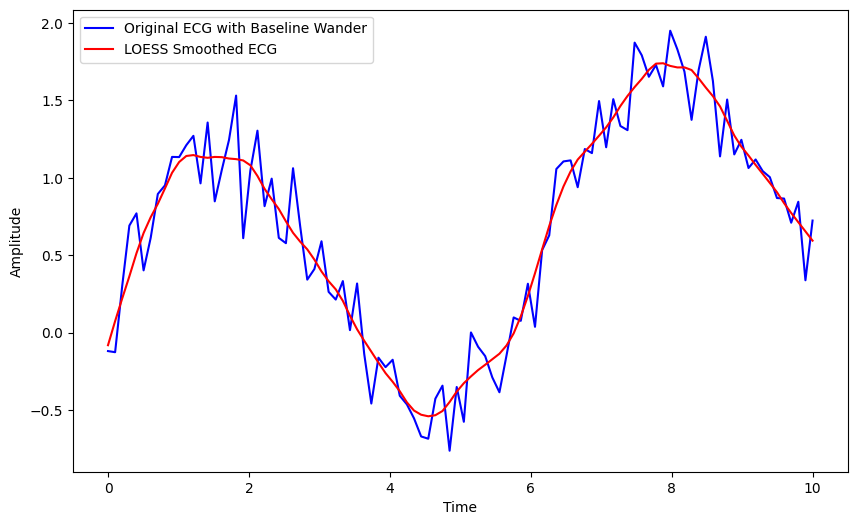

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Simulated ECG signal with baseline wander
x = np.linspace(0, 10, 100)
y = np.sin(x) + 0.2 * np.random.randn(100) + 0.1 * x  # Adding baseline drift

# Apply LOESS
lowess = sm.nonparametric.lowess(y, x, frac=0.1)  # frac controls the smoothing
y_smooth = lowess[:, 1]

# Plot the original and smoothed signal
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Original ECG with Baseline Wander', color='blue')
plt.plot(x, y_smooth, label='LOESS Smoothed ECG', color='red')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


Non-Local Means (NLM): Este método se basa en la idea de que los píxeles similares en una imagen tienen una alta probabilidad de pertenecer al mismo objeto o textura. NLM calcula un valor promedio ponderado para cada píxel, considerando los valores de los píxeles vecinos en una región más grande. Los pesos se asignan en función de la similitud entre los parches centrados en cada píxel. es usado porque: -Preservación de bordes: NLM es muy eficaz en la reducción de ruido mientras preserva los bordes y los detalles finos de la imagen. -Aplicación en imágenes naturales: Es ampliamente utilizado en el procesamiento de imágenes naturales, como fotografías y videos. Denoising de imágenes con ruido gaussiano: Es particularmente eficaz en la -reducción de ruido gaussiano, que es uno de los tipos de ruido más comunes en las imágenes digitales. En el articulo se empleo el método NLM para eliminar el ruido residual en la señal del ECG después de aplicar el filtro LOESS. NLM explota la redundancia presente en las señales naturales, como el ECG, para estimar el valor de cada punto a partir de una combinación ponderada de los valores de los puntos vecinos. Al considerar la similitud entre parches locales de la señal, NLM logra eliminar el ruido sin difuminar los bordes y preservando así las características detalladas del ECG. De esta manera, NLM permitió obtener una señal más limpia y de mejor calidad, facilitando su posterior análisis y diagnóstico. [1]

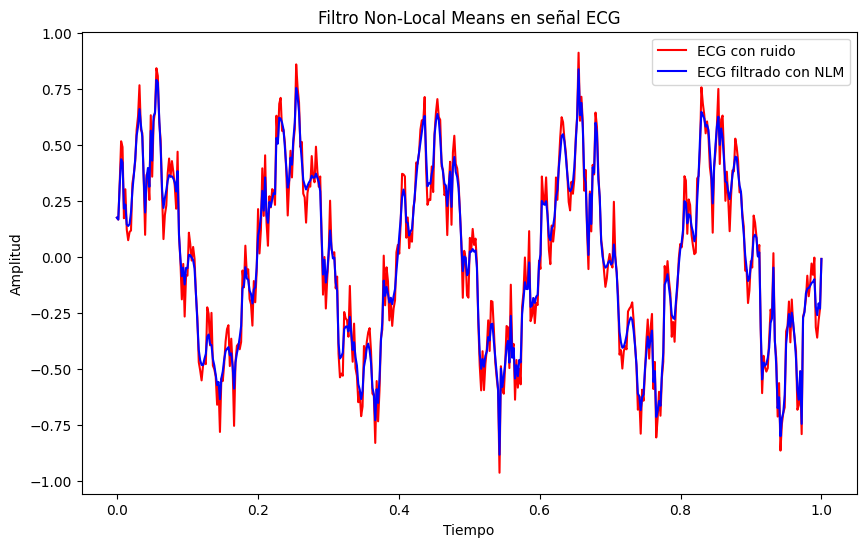

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Función para el filtro Non-Local Means en 1D
def nl_means_1d(signal, h=0.2, patch_size=5, patch_distance=10):
    """
    Aplica un filtro Non-Local Means a una señal 1D.
    
    Parámetros:
    - signal: array 1D de la señal a suavizar.
    - h: parámetro de suavizado. Valores más altos aumentan el suavizado.
    - patch_size: tamaño de cada parche para comparación.
    - patch_distance: distancia máxima para buscar parches similares.
    
    Retorna:
    - Señal suavizada.
    """
    denoised_signal = np.zeros_like(signal)
    weights_sum = np.zeros_like(signal)
    half_patch = patch_size // 2

    for i in range(len(signal)):
        # Definir el parche actual
        ref_patch_start = max(0, i - half_patch)
        ref_patch_end = min(len(signal), i + half_patch + 1)
        ref_patch = signal[ref_patch_start:ref_patch_end]
        
        # Variables para acumular el promedio ponderado
        patch_weight_sum = 0
        patch_value_sum = 0

        # Comparar con parches en la vecindad
        for j in range(max(0, i - patch_distance), min(len(signal), i + patch_distance + 1)):
            # Definir el parche vecino
            neighbor_patch_start = max(0, j - half_patch)
            neighbor_patch_end = min(len(signal), j + half_patch + 1)
            neighbor_patch = signal[neighbor_patch_start:neighbor_patch_end]
            
            # Asegurarse de que los parches tengan el mismo tamaño
            if len(ref_patch) != len(neighbor_patch):
                continue
            
            # Calcular la distancia euclidiana entre los parches
            distance = np.sum((ref_patch - neighbor_patch) ** 2)
            
            # Calcular el peso para el parche vecino
            weight = np.exp(-distance / (h ** 2))
            patch_weight_sum += weight
            patch_value_sum += weight * signal[j]
        
        # Asignar el valor denoised al punto actual
        denoised_signal[i] = patch_value_sum / patch_weight_sum if patch_weight_sum > 0 else signal[i]

    return denoised_signal

# Generar una señal ECG de ejemplo con ruido
np.random.seed(0)
time = np.linspace(0, 1, 500)
ecg_signal = 0.5 * np.sin(2 * np.pi * 5 * time) + 0.2 * np.sin(2 * np.pi * 40 * time)
ecg_signal += 0.1 * np.random.normal(size=time.shape)  # Añadir ruido

# Aplicar el filtro Non-Local Means a la señal
denoised_ecg = nl_means_1d(ecg_signal, h=0.3, patch_size=5, patch_distance=10)

# Graficar la señal original y la señal filtrada
plt.figure(figsize=(10, 6))
# plt.subplot(2,1,1)
plt.plot(time, ecg_signal, label="ECG con ruido", color='red')
# plt.subplot(2,1,1)
plt.plot(time, denoised_ecg, label="ECG filtrado con NLM", color='blue')
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")
plt.legend()
plt.title("Filtro Non-Local Means en señal ECG")
plt.show()

en conclusion, el artículo demuestra que la combinación de LOESS y NLM, junto con un filtro de paso bajo, es una estrategia efectiva para preprocesar señales ECG y eliminar diversos tipos de ruido. Esta combinación permite obtener señales más limpias y de mejor calidad, lo que facilita su análisis posterior y la extracción de características relevantes para el diagnóstico médico.


2. Descargar los datos ECGData.zip de:
https://figshare.com/collections/ChapmanECG/4560497/1

De la base de datos extraer los registros que correspondan a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). Esta información está en el archivo Diagnostics.xlsx

### Carga de librerias

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import detrend
from scipy.signal import welch
from numpy.polynomial.polynomial import Polynomial
import os
import pywt
from scipy import stats
import random
from scipy.stats import shapiro, levene, mannwhitneyu
import seaborn as sns

### Carga de datos Diagnostics.xlsx

In [2]:
fs=500

# ruta_diagnostics= r"C:\Users\Lenovo a9 w10\Documents\LabBiosenales\Proyecto_2/Diagnostics.xlsx"
ruta_diagnostics="./datos/Diagnostics.xlsx"
df_diagnostics = pd.read_excel(ruta_diagnostics)

# Crear el nuevo dataframe filtrando por la columna 'Rhythm'
datos_diagnostics = df_diagnostics[(df_diagnostics['Rhythm'] == 'SB') | (df_diagnostics['Rhythm'] == 'AFIB')]

#Tamaño del nuevo dataframe
datos_diagnostics.shape

tiempo_diagnostics = np.arange(0, datos_diagnostics.shape[0]/fs,1/fs)

datos_diagnostics.head()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
5,MUSE_20180112_120347_79000,SB,NONE,46,FEMALE,57,57,70,404,393,38,24,9,225,260,427
6,MUSE_20180114_075026_69000,AFIB,TWC,80,FEMALE,98,86,74,360,459,69,83,17,215,252,395


3. Consultar que otros tipos de señales wavelet se pueden usar para el análisis de señales ECG y adaptar el código del filtro wavelet que se entrega en el curso de acuerdo a la consulta (10%)

"La transformada wavelet (WT) tiene buenas propiedades de localización de tiempo-frecuencia y puede proporcionar análisis de señales en tiempo y escala. Al mismo tiempo, su propiedad de resolución múltiple puede representar las características no estacionarias de las señales. Por lo tanto, se ha convertido en uno de los métodos de eliminación de ruido que se utilizan comúnmente para las señales de ECG" [2]

Familias de Wavelet [3]

Wavelet de Daubechies: Son wavelets ortogonales con un número variable de coeficientes. Se utilizan ampliamente debido a su buena localización en tiempo y frecuencia y a su capacidad para capturar detalles finos de la señal.

Wavelet de Haar: Son las wavelets más simples y ortogonales. Son útiles para detectar cambios bruscos en la señal, como los complejos QRS.

Wavelet de Coiflets: Son similares a las wavelets de Daubechies, pero tienen momentos nulos de mayor orden, lo que las hace más suaves.

Wavelet de Symlets: Son wavelets simétricas y ortogonales, lo que las hace útiles para el análisis de señales simétricas.

Wavelet de Morlet: Son wavelets complejas con una parte real gaussiana y una parte imaginaria sinusoidal. Se utilizan comúnmente en el análisis de señales no estacionarias.

elegir n wavelets depende de varios factores como: *Tipo de característica a extraer: *Si se busca detectar cambios bruscos, como los complejos QRS, las wavelets de Haar pueden ser una buena opción. Si se busca analizar la forma de onda de los componentes del ECG, las wavelets de Daubechies o Coiflets pueden ser más adecuadas.

Nivel de ruido: Las wavelets con mayor número de coeficientes, como las Daubechies con un número elevado de coeficientes, suelen ser más robustas al ruido.

Longitud de la señal: Para señales cortas, pueden ser más adecuadas las wavelets con menos coeficientes.

aplicacion en ECG:

Detección de los complejos QRS: Las wavelets permiten detectar con precisión los complejos QRS, que son la parte más característica del ECG.

Análisis de la frecuencia cardíaca: Al analizar los coeficientes de la transformada wavelet, se puede obtener información sobre la variabilidad de la frecuencia cardíaca.

Detección de arritmias: Las wavelets pueden ayudar a identificar patrones anormales en el ECG que pueden indicar la presencia de arritmias.

Compresión de señales ECG: Las wavelets permiten una compresión eficiente de las señales ECG, reduciendo el tamaño de los archivos sin perder información relevante.

En un estudio realizado en 2016 aplicaron dos wavelets Daubechies en ECG,con dos escalas en particular, 4 y 6, con el objetivo de detectar los complejos QRT e intervalos QT. Obteniendo mejores resultados con un nivel de descomposición de 4, por esta razón se eligió 4 como nivel de descomposición. [4]

### Filtro Wavelet dado en el curso

In [138]:
def wnoisest(coeff):
    stdc = np.zeros((len(coeff),1));
    for i in range(0,len(coeff)):
        stdc[i] = (np.median(np.absolute(coeff[i])))/0.6745;
    return stdc;

In [139]:
def threshold(coeff):
    Num_samples = 0;
    for i in range(0,len(coeff)):
        Num_samples = Num_samples + coeff[i].shape[0];
    
    thr = np.sqrt(2*(np.log(Num_samples)))
    return thr

In [140]:
def wthresh(coeff):
    y   = list();
    s = wnoisest(coeff);
    print(s)
    thr = threshold(coeff)
    print(thr)
    for i in range(0,len(coeff)):
        y.append(np.multiply(coeff[i],np.abs(coeff[i])>(thr*s[i])));
    return thr,s,y;

In [12]:

def filt_wav(dato):
    # data=datos_II[dato]
    data=dato
    LL = int(np.floor(np.log2(data.shape[0])));

    data_wavelet = pywt.wavedec( data, 'db6', level=8 );
    print(len(data_wavelet))

    details = data_wavelet[1:]
    print(len(details))
    


### Filtro wavelet para usar

In [ ]:
def filtro_wavelet(signal_data, wavelet='db4', nivel=4):
    coeffs = pywt.wavedec(signal_data, wavelet, level=nivel)
    umbral = np.median(np.abs(coeffs[-1])) / 0.6745
    coeffs = [pywt.threshold(c, umbral, mode='soft') for c in coeffs]
    return pywt.waverec(coeffs,wavelet)



4. Escoger 10 señales al azar y aplicar un flujo de procesamiento

In [4]:
def cargar_datos(selected_files):
    # Diccionario para almacenar cada DataFrame y su columna 'II'
    data_frames = {}
    datos_II = {}
    
    # Iterar sobre los archivos en la lista
    for i, file in enumerate(selected_files):
        # Leer cada archivo y guardarlo en el diccionario con un nombre único
        # df = pd.read_csv(fr"C:\Users\Lenovo a9 w10\Downloads\Proyecto3\ECGDataDenoised/{file}.csv", delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
        df = pd.read_csv(f"./datos/ECGDataDenoised/{file}.csv", delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
        data_frames[f"df{i+1}"] = df
        # datos_II[f"datos_f{i+1}"] = df["II"]
        datos_II[f"{file}"] = df["II"]
    
    return data_frames, datos_II


In [5]:
# Separar nombres de archivo en listas según el ritmo 'SB' y 'AFIB'
sb_files = datos_diagnostics[datos_diagnostics['Rhythm'] == 'SB']['FileName'].tolist()
afib_files = datos_diagnostics[datos_diagnostics['Rhythm'] == 'AFIB']['FileName'].tolist()

In [6]:
# Número total de archivos a seleccionar
n_seleccion = 10

# Calcular la mitad para cada ritmo (o una distribución casi mitad y mitad si n_seleccion es impar)
n_sb = n_seleccion // 2
n_afib = n_seleccion - n_sb

# Seleccionar aleatoriamente el número calculado de archivos de cada tipo
selected_sb_files = random.sample(sb_files, min(n_sb, len(sb_files)))
selected_afib_files = random.sample(afib_files, min(n_afib, len(afib_files)))

# Combinar las selecciones de 'SB' y 'AFIB' en la lista final
selected_files = selected_sb_files + selected_afib_files

# Mezclar los archivos seleccionados para no tener un orden específico de 'SB' o 'AFIB'
random.shuffle(selected_files)
# Filtrar el DataFrame para obtener solo las filas de los archivos en selected_files
selected_data = datos_diagnostics[datos_diagnostics['FileName'].isin(selected_files)]

# Crear un diccionario con 'FileName' como clave y 'Rhythm' como valor para fácil acceso
file_rhythm_dict = dict(zip(selected_data['FileName'], selected_data['Rhythm']))

In [7]:
data_frames, datos_II = cargar_datos(selected_files)

In [7]:
datos_II.keys()

dict_keys(['MUSE_20180112_071020_91000', 'MUSE_20180118_173552_05000', 'MUSE_20180113_182542_46000', 'MUSE_20180116_133611_14000', 'MUSE_20180116_123306_96000', 'MUSE_20180116_133941_01000', 'MUSE_20180120_123509_87000', 'MUSE_20180116_170247_45000', 'MUSE_20180712_160535_83000', 'MUSE_20180115_124624_14000'])

### Flujos de trabajo

### Flujo 1
1. Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR
2. Filtro wavelet modificado del punto 3
3. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

In [6]:
# Flujo 1: Filtro pasa-altas, Filtro wavelet, Filtro pasabajas
def flujo_1(data,fs = 1000 ):
    # Paso 1: Filtro pasa-altas IIR a 0.5 Hz
    cutoff = 0.5  # Frecuencia de corte en Hz
    sos = signal.butter(4, cutoff, btype='highpass', fs=fs, output='sos')
    data_highpass = signal.sosfilt(sos, data)
    
    # Paso 2: Filtro wavelet
    data_denoised=filtro_wavelet(data_highpass, wavelet='db4', nivel=4)
    # wavelet='db4'
    # coeffs = pywt.wavedec(data_highpass, wavelet, level=4)
    # umbral = np.median(np.abs(coeffs[-1])) / 0.6745
    # coeffs = [pywt.threshold(c, umbral, mode='soft') for c in coeffs]
    # data_denoised = pywt.waverec(coeffs, wavelet)
 
    
    # Paso 3: Filtro pasabajas IIR a 50 Hz
    cutoff = 50  # Frecuencia de corte en Hz
    sos = signal.butter(4, cutoff, btype='lowpass', fs=fs, output='sos')
    data_lowpass = signal.sosfilt(sos, data_denoised)
    
    return data_lowpass



### Flujo 2
1. Detrend
2. Filtro wavelet modificado del punto 3
3. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

In [7]:
# Flujo 2: Detrend, Filtro wavelet, Filtro pasabajas
def flujo_2(data,fs = 1000 ):
    # Paso 1: Detrend
    data_detrended = signal.detrend(data)
    
    # Paso 2: Filtro wavelet
    data_denoised=filtro_wavelet(data_detrended, wavelet='db4', nivel=4)
    # wavelet='db4'
    # coeffs = pywt.wavedec(data_detrended, wavelet, level=4)
    # umbral = np.median(np.abs(coeffs[-1])) / 0.6745
    # coeffs = [pywt.threshold(c, umbral, mode='soft') for c in coeffs]
    # data_denoised = pywt.waverec(coeffs, wavelet)
    
    # Paso 3: Filtro pasabajas IIR a 50 Hz
    cutoff = 50  # Frecuencia de corte en Hz
    sos = signal.butter(4, cutoff, btype='lowpass', fs=fs, output='sos')
    data_lowpass = signal.sosfilt(sos, data_denoised)
    
    return data_lowpass

### Flujo 3
1. Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR
2. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

In [8]:
# Flujo 3: Filtro pasa-altas, Filtro pasabajas
def flujo_3(data,fs = 1000 ):
    # Paso 1: Filtro pasa-altas IIR a 0.5 Hz
    cutoff = 0.5  # Frecuencia de corte en Hz
    sos = signal.butter(4, cutoff, btype='highpass', fs=fs, output='sos')
    data_highpass = signal.sosfilt(sos, data)
    

    # Paso 2: Filtro pasabajas IIR a 50 Hz
    cutoff = 50  # Frecuencia de corte en Hz
    sos = signal.butter(4, cutoff, btype='lowpass', fs=fs, output='sos')
    data_lowpass = signal.sosfilt(sos, data_highpass)
    
    return data_lowpass

MUSE_20180115_134536_37000


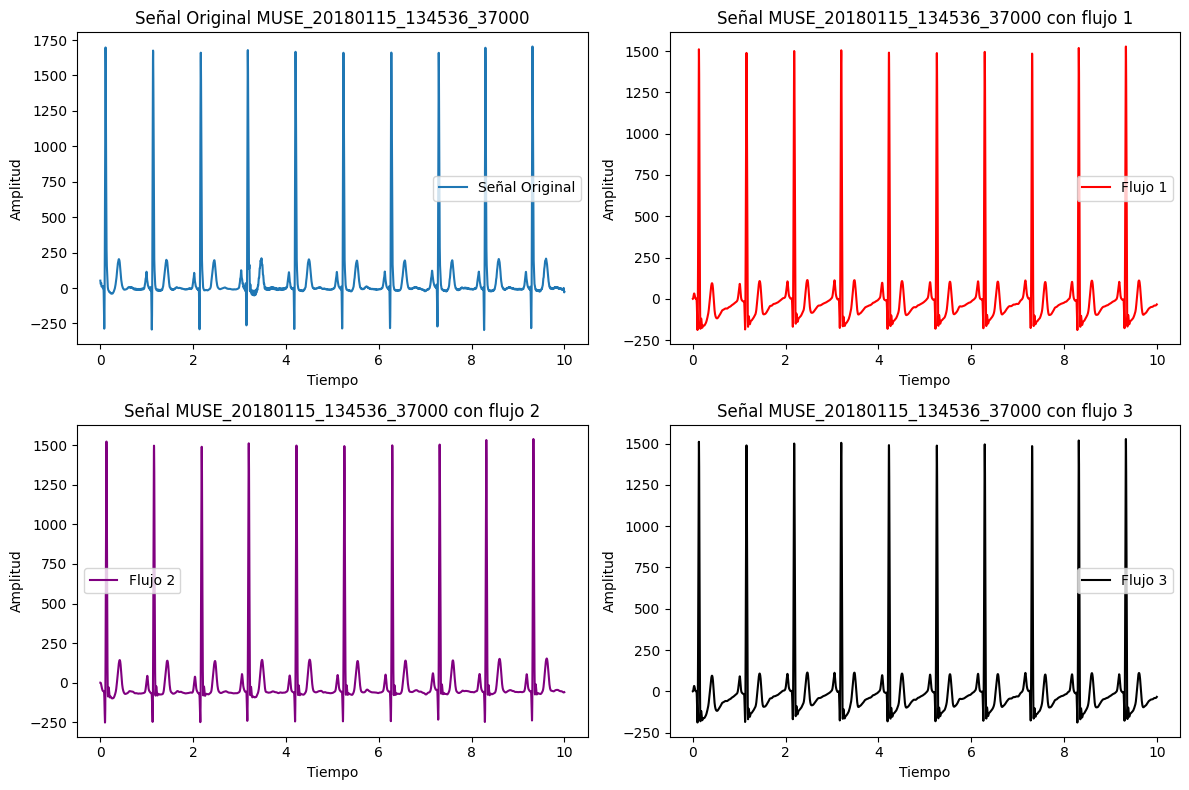

MUSE_20180116_180012_70000


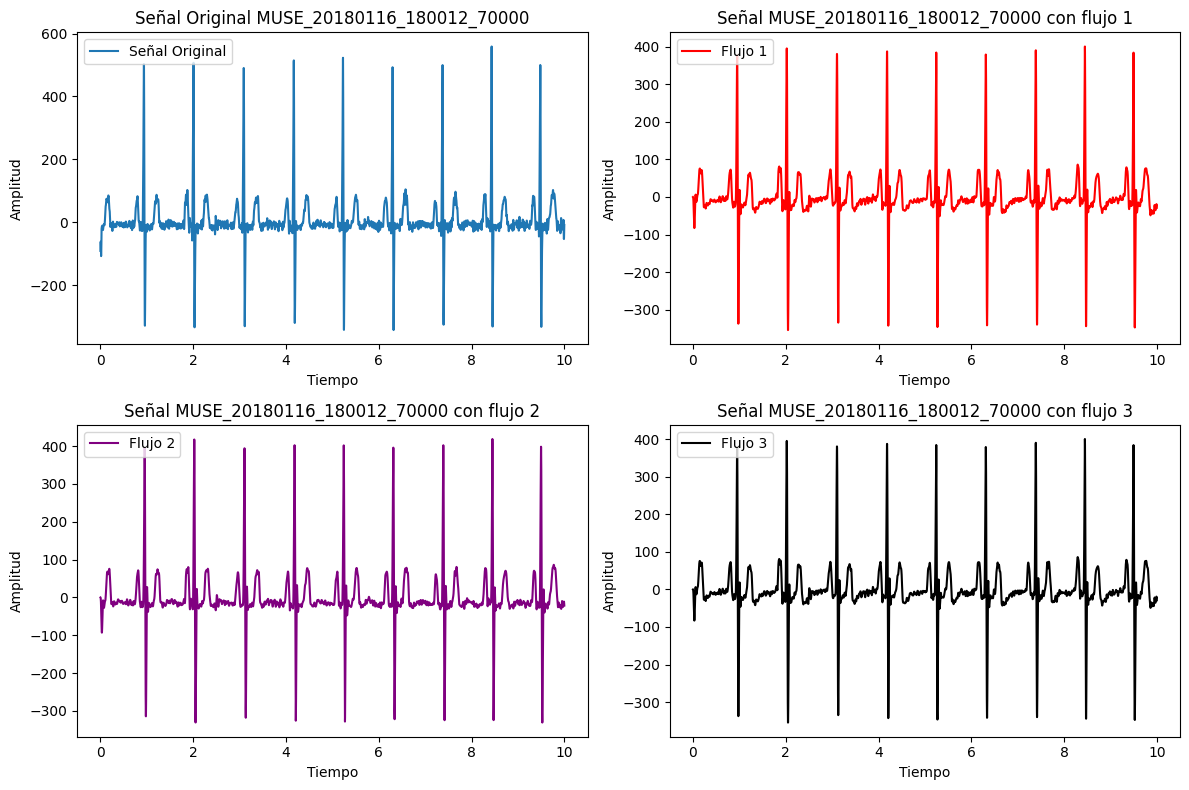

MUSE_20180112_140219_83000


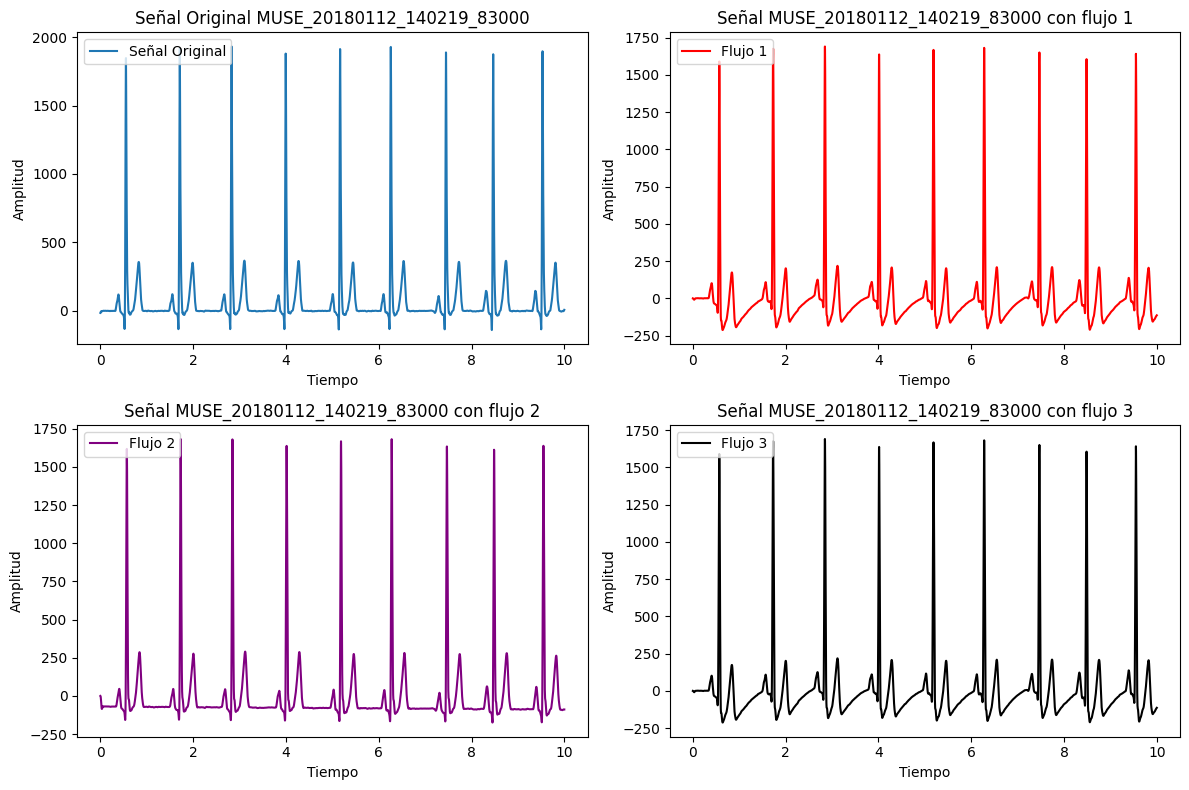

MUSE_20180112_135717_94000


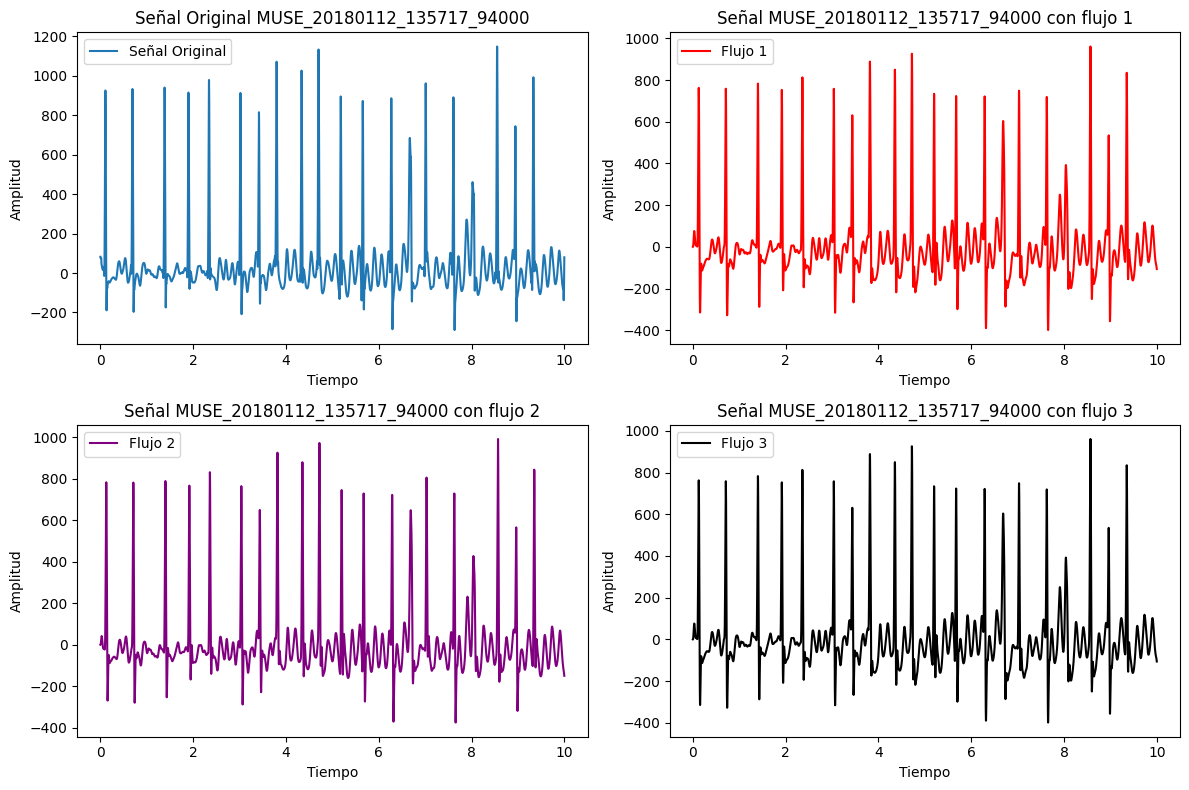

MUSE_20180113_071932_50000


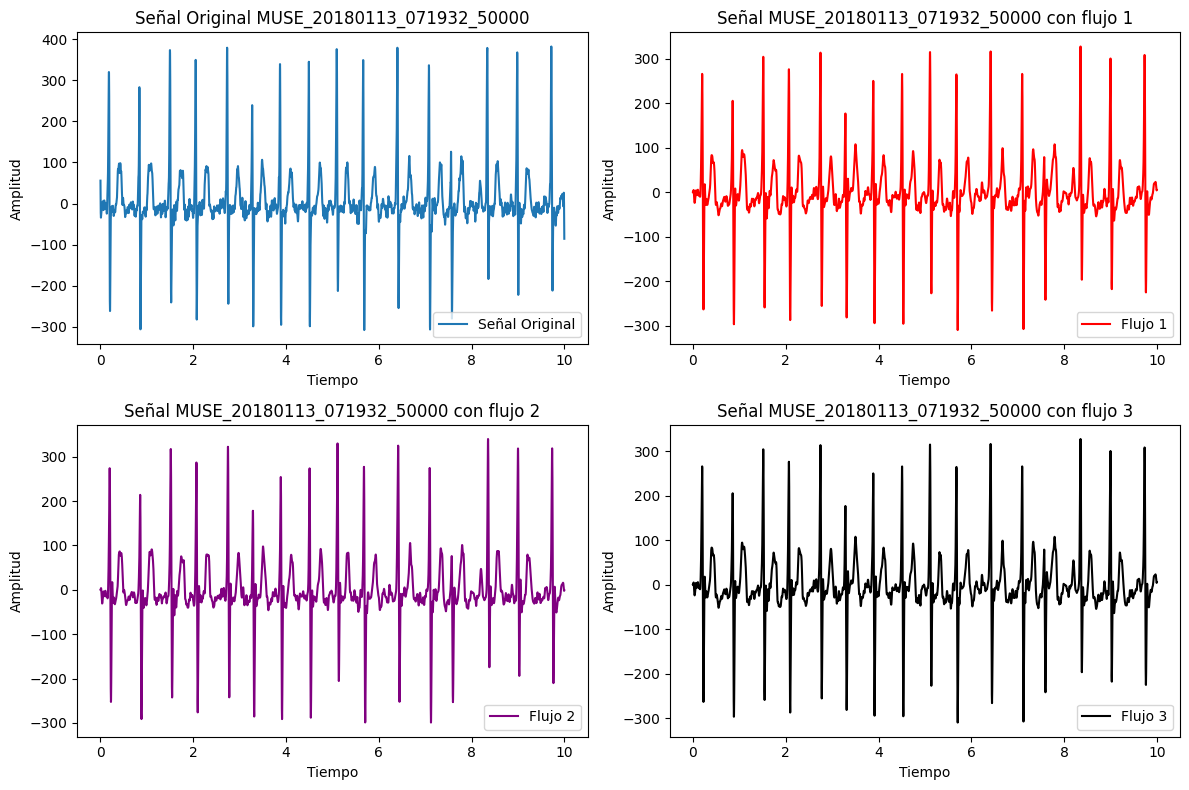

MUSE_20180114_135441_04000


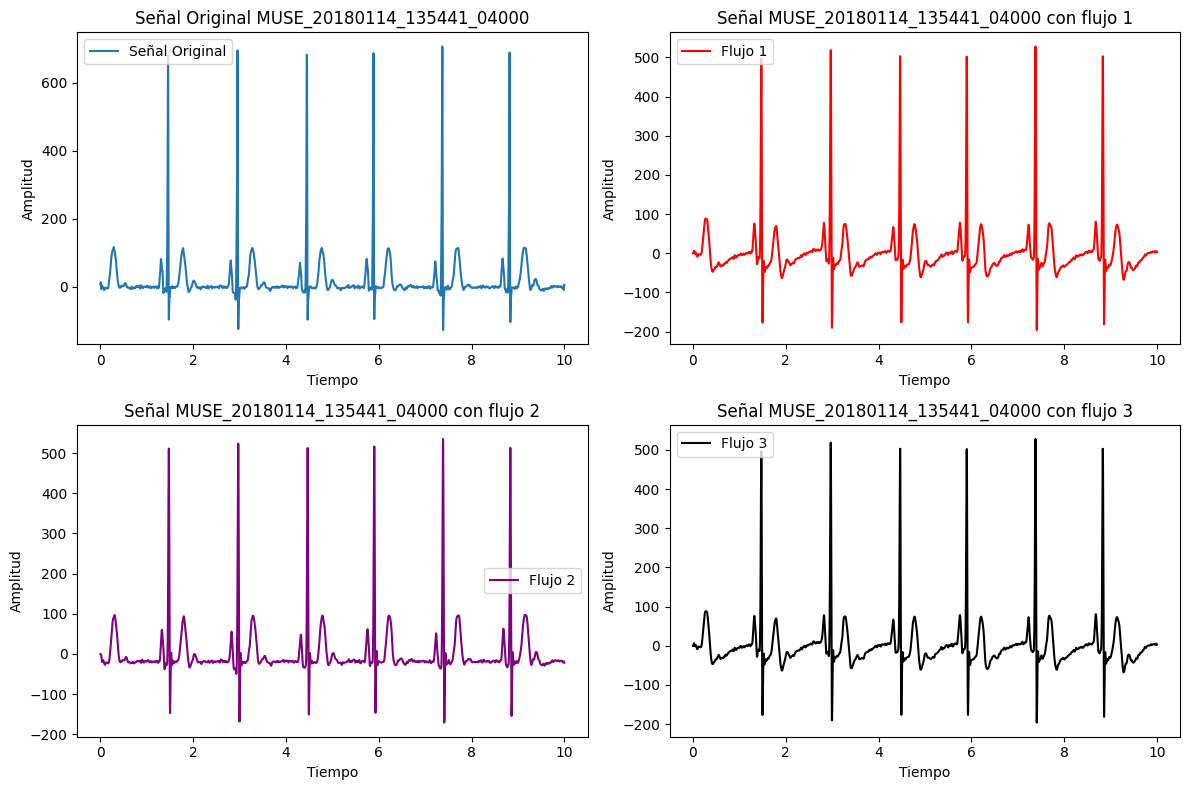

MUSE_20180112_132529_40000


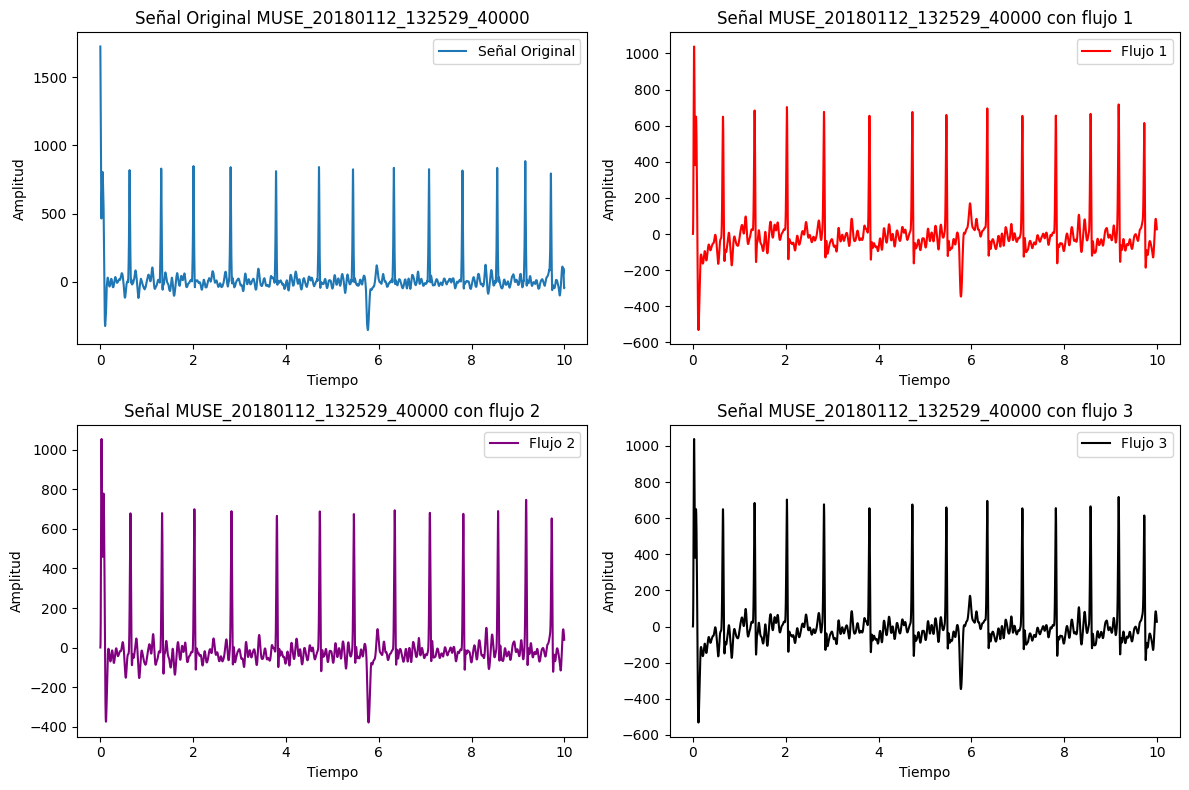

MUSE_20180118_181541_69000


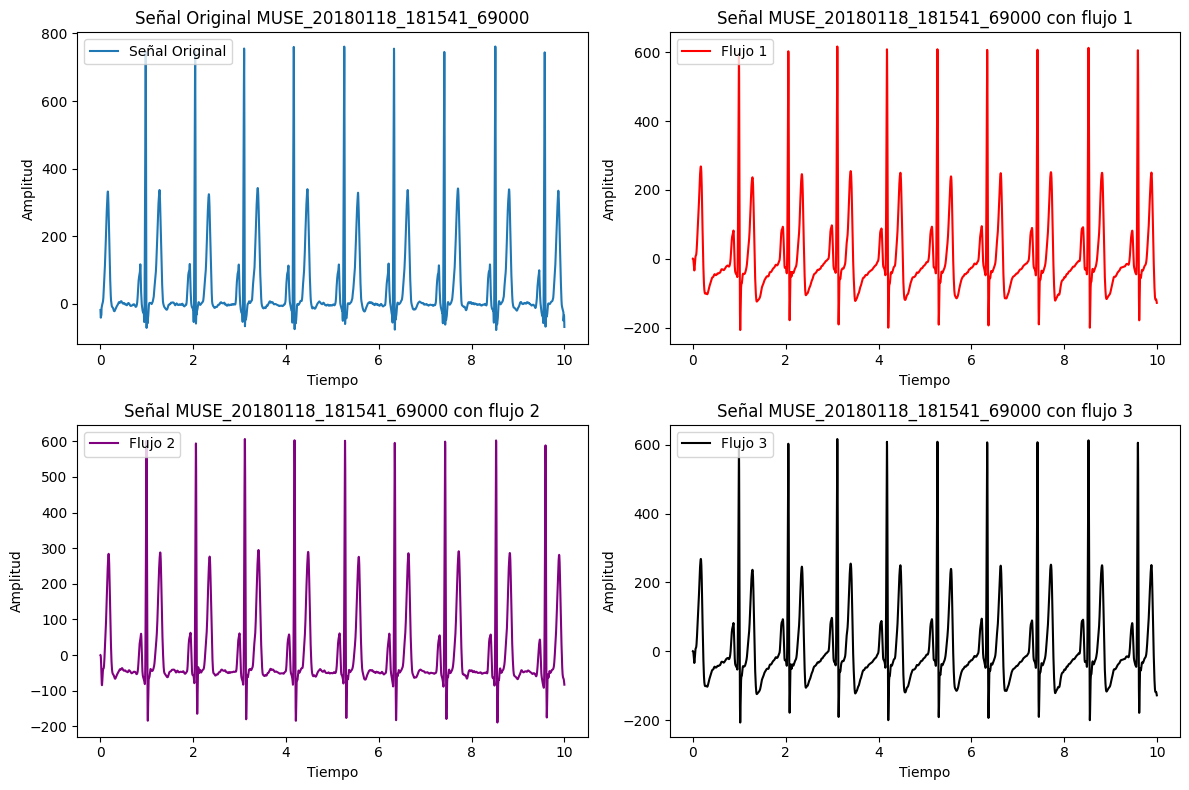

MUSE_20180115_133936_95000


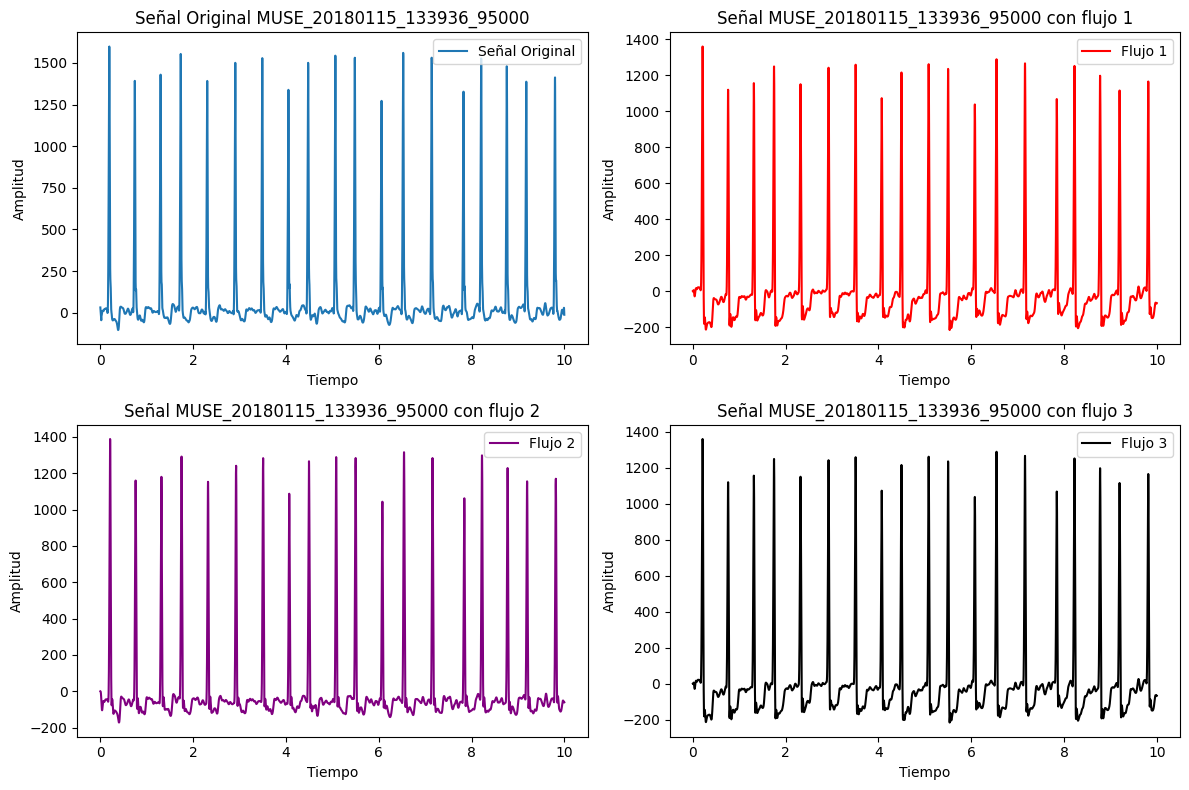

MUSE_20180116_120804_20000


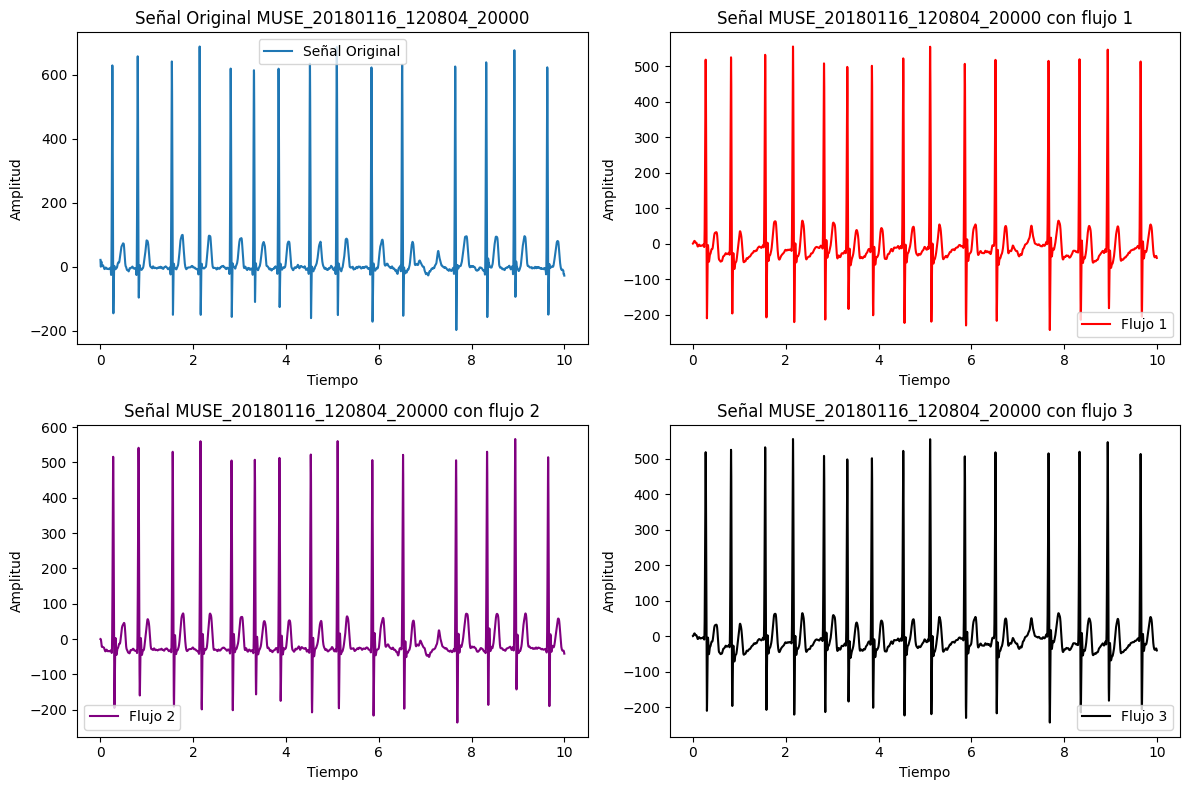

In [64]:
#Aplicación de flujos
for archivo in selected_files:
    # Leer el archivo CSV
    # df = pd.read_csv(fr"C:\Users\Lenovo a9 w10\Downloads\Proyecto3\ECGDataDenoised/{archivo}.csv", delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    df = pd.read_csv(f"../Proyecto_3/datos/ECGDataDenoised/{archivo}.csv", delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    datos_II=df["II"]
    print(archivo)
    proc_signal_1=flujo_1(datos_II)
    proc_signal_2=flujo_2(datos_II)
    proc_signal_3=flujo_3(datos_II)
    tiempo = np.arange(0, datos_II.shape[0]/fs,1/fs)
    
    # Graficar señal prefiltrada, señal original y señal procesada
    # plt.figure()
    plt.figure(figsize=(12, 8))
    
    
    plt.subplot(2, 2, 1)
    plt.plot(tiempo,datos_II, label='Señal Original')
    plt.title(f'Señal Original {archivo}')
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.legend()
    
    
    plt.subplot(2, 2, 2)
    plt.plot(tiempo,proc_signal_1, label='Flujo 1', color="red")
    plt.title(f'Señal {archivo} con flujo 1')
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.legend()


    plt.subplot(2, 2, 3)
    plt.plot(tiempo,proc_signal_2, label='Flujo 2', color='purple')
    plt.title(f'Señal {archivo} con flujo 2')
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(tiempo,proc_signal_3, label='Flujo 3', color="black")
    plt.title(f'Señal {archivo} con flujo 3')
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.legend()

    plt.tight_layout()
    plt.show()


### Describir los resultados obtenidos y decidir si el resto del procesamiento se hace con el flujo 1, el flujo 2 o el flujo 3 (20%)

El flujo que se seleccionará para el procesamiento será aquel que devuelva una señal lo más parecida posible a la señal original. Al aplicar los tres flujos de filtrado, se observa que las señales se ven afectadas de diferentes maneras, principalmente en la amplitud, que se reduce ligeramente en todos los casos. Sin embargo, hay diferencias más notables entre los flujos:

Flujos 1 y 3: En ambos se observan zonas donde la señal se deforma, lo que afecta su representación general. Estas deformaciones pueden ser interpretadas como distorsiones que alteran las características de la señal original, lo que hace que no sean tan ideales para mantener la fidelidad con la señal original.

Flujo 2: Este flujo presenta la menor cantidad de deformaciones y, visualmente, la señal procesada es la que más se asemeja a la señal original. Las características importantes de la señal se preservan, y las alteraciones no son evidentes, lo que lo convierte en el flujo preferido para obtener una señal lo más fiel posible a la original.

Por lo tanto, el flujo 2 es el que se seleccionará, ya que minimiza las deformaciones y mantiene la mayor similitud con la señal original.

## Ecuaciones proyecto 2

In [9]:
def Grafica(tiempo,data,datos_process,nombre="Procesado"):
    
    # Crear una figura con dos subplots en una fila
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 4))
    # Graficar en el primer subplot
    ax1.plot(tiempo,data, color="k")
    ax1.set_title('Original')
    ax1.grid(True)
    # Graficar en el segundo subplot
    ax2.plot(tiempo,datos_process, color="r", linestyle='-')
    ax2.set_title(nombre)
    ax2.grid(True)
    plt.show()

In [14]:
#Ecuación 1
def detrend_n_deviation(data,tiempo):
    datos_detrend=signal.detrend(data)
    datos_deviation=np.mean((data-datos_detrend)**2)
    return datos_detrend, datos_deviation

In [15]:
# Ecuación 2
def compress(signal):
    xmin, xmax = np.min(signal), np.max(signal)
    if xmin == xmax:
        return signal  # Evitar dividir por cero si no hay rango
    compressed_signal = (signal - xmin) / (xmax - xmin)
    return np.array(compressed_signal)

In [32]:
#Ecuaciones 3 y 4
def bispectrum_bicoherence(signal, fs, segment):
    # Dividir la señal en segmentos de longitud nfft
    segmentos = [signal[i:i + segment] for i in range(0, len(signal) - segment + 1, segment)]
    segmentos = np.array(segmentos)
    num_segmentos = segmentos.shape[0]

    # Aplicar la Transformada de Fourier a cada segmento
    fft_segmentos = np.fft.fft(segmentos, n=segment, axis=1)[:, :segment // 2]

    # Inicializar matrices para el bispectro y la bicoherencia
    bispectro = np.zeros((segment // 2, segment // 2), dtype=complex)

    # Calcular el bispectro y el valor acumulado para la bicoherencia
    for k in range(num_segmentos):
        S = fft_segmentos[k, :]
        for f1 in range(segment // 2):
            for f2 in range(f1, segment // 2 - f1):
                f3 = f1 + f2
                if f3 < segment // 2:  # Evitar exceder los límites del espectro
                    producto = S[f1] * S[f2] * np.conj(S[f3])
                    bispectro[f1, f2] += producto

    return bispectro



5. Para cada señal extraer la frecuencia que contiene la máxima potencia usando Welch (15%)

In [ ]:
# Para cada señal extraer la frecuencia que contiene la máxima potencia y Gráfiquela 
def obtener_frecuencia_maxima_potencia(df, fs=1000):
    nperseg = 1024 
    noverlap = int(nperseg / 2)  
    ventana = np.hamming(nperseg)  
    
    # Calcular la densidad espectral de potencia utilizando Welch
    frecuencias, potencia = welch(df, fs=fs,window=ventana, nperseg=nperseg, noverlap=noverlap)

    # Encontrar la frecuencia con la máxima potencia
    indice_max_potencia = potencia.argmax()
    frecuencia_max = frecuencias[indice_max_potencia]

    return frecuencia_max


Almacene los resultados en un dataframe donde se pueda registro, tipo de patología y frecuencia de máxima potencia (fMP) :

| Registro | Estado | fMP |
| --- | --- | --- |
| --- | --- | --- | 
| --- | --- | --- | 


6. Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 3 al 5 y almacene los resultados en un dataframe donde se pueda registro, tipo de patología y el frecuencia de máxima potencia (fMP):

In [ ]:
def signal_process(datos,tiempo,fs):
    print("Aplicando detrend")
    data_detrended=detrend_n_deviation(datos,tiempo)
    print(f'La desviación es {data_detrended[1]}')
    # Grafica(tiempo,datos,data_detrended[0],nombre="Detrended")

    print("Aplicando compress")
    data_compressed=compress(data_detrended[0])
    # Grafica(tiempo,data_detrended[0],data_compressed,"Compressed")

    print("Aplicando biespectro y bicoherencia")
    bisp_Bic=bispectrum_bicoherence(data_compressed,fs,1000)
 

    print("calculando la máxima potencia")
    max_p=obtener_frecuencia_maxima_potencia(datos,fs)
    print(f'La máxima potencia es {[max_p]} \n')

    # return data_detrended, data_compressed, bisp_Bic, max_p, sig_f
    return data_detrended, data_compressed, bisp_Bic, max_p

### Aplicar procesado a señal de derivada II por metodo proyecto 2

7. Para las señales de análisis del punto 2 aplicar las rutinas del punto 3 al 5 y hacer un informe que permita evidenciar las diferencias entre las señales SB y AFIB utilizando las herramientas de estadística descriptiva (5%)

In [ ]:
#Prueba con 10 sujetos
df_resultados = pd.DataFrame(columns=["Registro", "Estado", "fMP"])

for archivo in selected_files:
    # Leer el archivo CSV
    # df = pd.read_csv(fr"C:\Users\Lenovo a9 w10\Downloads\Proyecto3\ECGDataDenoised/{archivo}.csv", delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    df = pd.read_csv(f"../Proyecto_3/datos/ECGDataDenoised/{archivo}.csv", delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    datos_II=df["II"]
    tiempo = np.arange(0, datos_II.shape[0]/fs,1/fs)

# Obtener el nombre del sujeto (sin extensión .csv)
    nombre_sujeto = archivo[:-4] #Registro

# Procesar los archivos
    resultados_proceso=signal_process(datos_II,tiempo,fs)

    estado = file_rhythm_dict[archivo] #Estado

    F_max=resultados_proceso[3] #fMP
    
    df_resultados = pd.concat([df_resultados,
                    pd.DataFrame({'Registro': nombre_sujeto,
                                    'Estado': estado,
                                    'fMP': F_max},
                                index=[0])
                    ],
                    ignore_index=True)

Aplicando detrend
La desviación es 399.08218559335626
Aplicando compress
Aplicando biespectro y bicoherencia
calculando la máxima potencia
La máxima potencia es [np.float64(3.90625)] 

Aplicando detrend
La desviación es 3315.0048380840203
Aplicando compress
Aplicando biespectro y bicoherencia


C:\Users\crist\AppData\Local\Temp\ipykernel_16784\4133502405.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados = pd.concat([df_resultados,


calculando la máxima potencia
La máxima potencia es [np.float64(3.90625)] 

Aplicando detrend
La desviación es 6.2700228202177595
Aplicando compress
Aplicando biespectro y bicoherencia
calculando la máxima potencia
La máxima potencia es [np.float64(1.953125)] 

Aplicando detrend
La desviación es 2738.5607232496477
Aplicando compress
Aplicando biespectro y bicoherencia
calculando la máxima potencia
La máxima potencia es [np.float64(3.90625)] 

Aplicando detrend
La desviación es 1669.8893627027546
Aplicando compress
Aplicando biespectro y bicoherencia
calculando la máxima potencia
La máxima potencia es [np.float64(5.859375)] 

Aplicando detrend
La desviación es 197.35515152937853
Aplicando compress
Aplicando biespectro y bicoherencia
calculando la máxima potencia
La máxima potencia es [np.float64(9.765625)] 

Aplicando detrend
La desviación es 568.2128371251873
Aplicando compress
Aplicando biespectro y bicoherencia
calculando la máxima potencia
La máxima potencia es [np.float64(3.90625)]

In [62]:
df_resultados

,Registro,Estado,fMP
0,MUSE_20180119_170728_4,AFIB,3.906250
1,MUSE_20180118_174037_6,AFIB,1.953125
2,MUSE_20180113_185557_2,SB,1.953125
3,MUSE_20180118_130334_2,SB,3.906250
4,MUSE_20180712_160541_1,AFIB,3.906250
5,MUSE_20180116_173620_1,SB,7.812500
6,MUSE_20180112_075225_5,SB,1.953125
7,MUSE_20180118_130902_7,AFIB,3.906250
8,MUSE_20180116_133520_6,AFIB,3.906250
9,MUSE_20180116_130947_4,SB,1.953125


In [ ]:
# df_resultados.to_excel("Dataframe_P2_10Sujetos.xlsx", index=False)

# Para todos los datos

In [17]:
all_files = datos_diagnostics['FileName'].tolist()

In [18]:
# Filtrar el DataFrame para obtener solo las filas de los archivos en selected_files
selected_data_all = datos_diagnostics[datos_diagnostics['FileName'].isin(all_files)]

# Crear un diccionario con 'FileName' como clave y 'Rhythm' como valor para fácil acceso
file_rhythm_all = dict(zip(selected_data_all['FileName'], selected_data_all['Rhythm']))

## Procesado con funciones proyecto 2

In [ ]:
# Crear un DataFrame vacío para almacenar los resultados
df_resultados_all = pd.DataFrame(columns=["Registro", "Estado", "fMP"])

for archivo in all_files:
    # Leer el archivo CSV
    # df = pd.read_csv(fr"C:\Users\Lenovo a9 w10\Downloads\Proyecto3\ECGDataDenoised/{archivo}.csv", delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    df = pd.read_csv(f"../Proyecto_3/datos/ECGDataDenoised/{archivo}.csv", delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    datos_II=df["II"]
    tiempo = np.arange(0, datos_II.shape[0]/fs,1/fs)

# Obtener el nombre del sujeto (sin extensión .csv)
    nombre_sujeto = archivo[:-4] #Registro

# Procesar los archivos
    resultados_proceso=signal_process(datos_II,tiempo,fs)

    estado = file_rhythm_all[archivo] #Estado

    F_max=resultados_proceso[3] #fMP
    
    df_resultados_all = pd.concat([df_resultados_all,
                    pd.DataFrame({'Registro': nombre_sujeto,
                                    'Estado': estado,
                                    'fMP': F_max},
                                index=[0])
                    ],
                    ignore_index=True)

Aplicando detrend
La desviación es 74.91493430408316
Aplicando compress
Aplicando biespectro y bicoherencia
calculando la máxima potencia
La máxima potencia es [np.float64(9.765625)] 

Aplicando detrend
La desviación es 658.9745456437928
Aplicando compress
Aplicando biespectro y bicoherencia


C:\Users\crist\AppData\Local\Temp\ipykernel_16784\2226045268.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados_all = pd.concat([df_resultados_all,


calculando la máxima potencia
La máxima potencia es [np.float64(5.859375)] 

Aplicando detrend
La desviación es 1367.9985588590444
Aplicando compress
Aplicando biespectro y bicoherencia
calculando la máxima potencia
La máxima potencia es [np.float64(3.90625)] 



In [10]:
df_resultados_all

,Registro,Estado,fMP
0,MUSE_20180113_171327_2,AFIB,9.765625
1,MUSE_20180112_073319_2,SB,5.859375
2,MUSE_20180113_121940_4,SB,3.906250
3,MUSE_20180112_120347_7,SB,3.906250
4,MUSE_20180114_075026_6,AFIB,3.906250
...,...,...,...
5664,MUSE_20180114_134724_1,SB,3.906250
5665,MUSE_20180113_122544_2,SB,3.906250
5666,MUSE_20180114_074720_8,SB,11.718750
5667,MUSE_20180115_131524_9,AFIB,1.953125


In [ ]:
df_resultados_all.to_excel("Dataframe_P2.xlsx", index=False)

## Procesado con flujo 2

In [54]:
# Crear un DataFrame vacío para almacenar los resultados
df_resultados_flujo = pd.DataFrame(columns=["Registro", "Estado", "fMP"])

for archivo in all_files:
    # Leer el archivo CSV
    # df = pd.read_csv(fr"C:\Users\Lenovo a9 w10\Downloads\Proyecto3\ECGDataDenoised/{archivo}.csv", delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    df = pd.read_csv(f"../Proyecto_3/datos/ECGDataDenoised/{archivo}.csv", delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    datos_II=df["II"]
    tiempo = np.arange(0, datos_II.shape[0]/fs,1/fs)

# Obtener el nombre del sujeto (sin extensión .csv)
    nombre_sujeto = archivo[:-4] #Registro

# Procesar los archivos
    data_detrended1=detrend_n_deviation(datos_II,tiempo)
    data_compressed=compress(data_detrended1[0])
    data_detrended=detrend_n_deviation(data_compressed,tiempo)
    resultados_proceso=flujo_2(data_detrended[0],fs)

    estado = file_rhythm_all[archivo] #Estado
    
    F_max=obtener_frecuencia_maxima_potencia(resultados_proceso,fs)
    # F_max=resultados_proceso[3] #fMP
    
    df_resultados_flujo = pd.concat([df_resultados_flujo,
                    pd.DataFrame({'Registro': nombre_sujeto,
                                    'Estado': estado,
                                    'fMP': F_max},
                                index=[0])
                    ],
                    ignore_index=True)

C:\Users\crist\AppData\Local\Temp\ipykernel_5736\4047622354.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados_flujo = pd.concat([df_resultados_flujo,


In [55]:
df_resultados_flujo

,Registro,Estado,fMP
0,MUSE_20180113_171327_2,AFIB,13.183594
1,MUSE_20180112_073319_2,SB,3.417969
2,MUSE_20180113_121940_4,SB,3.417969
3,MUSE_20180112_120347_7,SB,3.906250
4,MUSE_20180114_075026_6,AFIB,4.394531
...,...,...,...
5664,MUSE_20180114_134724_1,SB,2.929688
5665,MUSE_20180113_122544_2,SB,0.976562
5666,MUSE_20180114_074720_8,SB,11.230469
5667,MUSE_20180115_131524_9,AFIB,1.464844


In [56]:
df_resultados_flujo.to_excel("Dataframe_P3.xlsx", index=False)

7. Comparar los resultados de fMP del proyecto 3 con los del proyecto 2 usando estadística descriptiva: gráficos y pruebas de hipótesis (15%) Discuta si hay más diferencias entre los tipos de señales con el flujo de procesamiento propuesto respecto al que se trabajó en el proyecto 2.

In [11]:
df_P2 = pd.read_excel("Dataframe_P2.xlsx", usecols=["Registro", "Estado", "fMP"])
df_P3 = pd.read_excel("Dataframe_P3.xlsx", usecols=["Registro", "Estado", "fMP"])

alpha = 0.05

In [12]:
# Extraer las columnas 'fMP' de cada dataframe
fmp1 = df_P2['fMP']
fmp2 = df_P3['fMP']

Fmp1 son las frecuencias Máximas de potencia de las señales del proyecto 2

Fmp2 son las de este proyecto 3, es decir, las señales con nuestros propios filtros

Prueba de Normalidad

Hipótesis nula (Ho): Las frecuencias de Máxima potencia de las señales prefiltradas en el proyecto 2/3 no distribuyen normal. 

Hipótesis alternativa (H1): Las frecuencias de Máxima potencia de las señales prefiltradas en el proyecto 2/3 distribuyen normal. 

In [12]:
# Prueba de Shapiro-Wilk para normalidad
stat1, p_value1 = shapiro(fmp1)
stat2, p_value2 = shapiro(fmp2)

# print("Prueba de normalidad para fMP del primer dataframe:")
# print(f"Estadístico: {stat1}, p-valor: {p_value1}")

# print("Prueba de normalidad para fMP del segundo dataframe:")
# print(f"Estadístico: {stat2}, p-valor: {p_value2}")

# Interpretación
if p_value1 > alpha:
    print(f"El dataframe con procesamiento del proyecto 2 sigue una distribución normal con valor-p: {p_value1}.")
else:
    print(f"El dataframe con procesamiento del proyecto 2 no sigue una distribución normal con valor-p: {p_value1}.")

if p_value2 > alpha:
    print(f"El dataframe con procesamiento con el flujo 2 sigue una distribución normal con valor-p: {p_value2}.")
else:
    print(f"El dataframe con procesamiento con el flujo 2 no sigue una distribución normal con valor-p: {p_value2}.")


El dataframe con procesamiento del proyecto 2 no sigue una distribución normal con valor-p: 1.7317766846544169e-71.
El dataframe con procesamiento con el flujo 2 no sigue una distribución normal con valor-p: 3.346394530991815e-64.


C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5669.
  res = hypotest_fun_out(*samples, **kwds)


Prueba Homocedasticidad  

Hipótesis nula (Ho): Las varianzas de las frecuencias de Maxima Potencia no son significativamente diferentes entre los dos proyectos (2 y 3).

Hipótesis alternativa (H1): Las varianzas de las frecuencias de Maxima Potencia son significativamente diferentes entre los dos proyectos (2 y 3)

In [ ]:
# Prueba de Levene para homocedasticidad
stat, p_value_h = levene(fmp1, fmp2)

# print("Prueba de homocedasticidad (Levene):")
# print(f"Estadístico: {stat}, p-valor: {p_value}")

# Interpretación
if p_value_h > alpha:
    print(f"Las varianzas son homogéneas (se cumple homocedasticidad) con valor-p: {p_value_h}.")
else:
    print(f"Las varianzas no son homogéneas (no se cumple homocedasticidad) con valor-p: {p_value_h}.")


Las varianzas no son homogéneas (no se cumple homocedasticidad) con valor-p:0.03204109944250029.


Prueba Mann-Whitney

Hipótesis nula (Ho): No hay diferencias entre las frecuencias de Maxima Potencia  obtenidas del proyecto 2 con las obtenidas mediante el filtrado propio ejecutado en el proyecto 3.

Hipótesis alternativa (H1): Hay diferencias entre las frecuencias de Maxima Potencia  obtenidas del proyecto 2 con las obtenidas mediante el filtrado propio ejecutado en el proyecto 3.

In [21]:
stat, p_value_m = mannwhitneyu(fmp1, fmp2, alternative='two-sided')
# print("\nPrueba de Mann-Whitney U:")
# print(f"Estadístico: {stat}, p-valor: {p_value}")
if p_value_m < alpha:
    print(f"Existen diferencias significativas entre ambos dataframes con valor-p: {p_value_m}.")
else:
    print(f"No existen diferencias significativas entre ambos dataframes con valor-p: {p_value_m}.")


Existen diferencias significativas entre ambos dataframes con valor-p: 1.219863658902743e-189.


Los datos no distribuyen normal, y además las varianzas entre ellas son significativas, por lo que se debara aplicar la prueba Mann-WHitney, la cuál nos indica que existen diferencias significativas entre estos dos conjuntos de datos, esto debido a que los flujos de procesamiento no fueron 100% adecuados ya que existe la posibilidad de que se escaparan algunas interferencias de bajas frecuencias, además cabe resaltar que las señalas prefiltradas del proyecto 2 pudieron ocupar otros métodos de filtrado que permitía tener una confiabilidad máxima de eliminación de datos que no son de interés

In [22]:
print("Primer dataframe:")
print(fmp1.describe())
print("Segundo dataframe:")
print(fmp2.describe())


Primer dataframe:
count    5669.000000
mean        4.313481
std         2.478247
min         1.953125
25%         3.906250
50%         3.906250
75%         3.906250
max        50.781250
Name: fMP, dtype: float64
Segundo dataframe:
count    5669.000000
mean        3.337608
std         2.193553
min         0.488281
25%         1.953125
50%         2.929688
75%         3.906250
max        49.804688
Name: fMP, dtype: float64


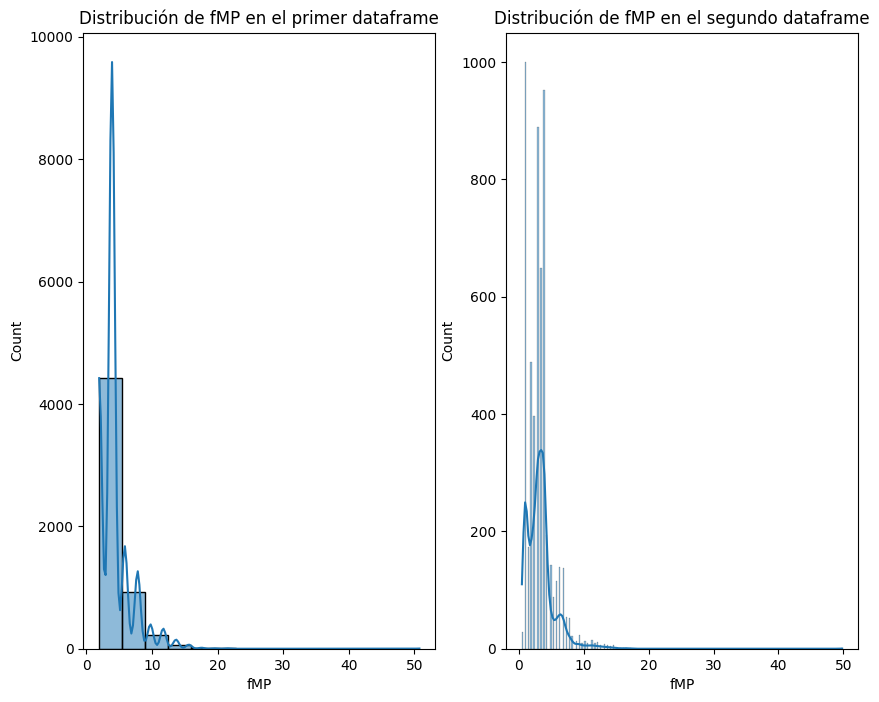

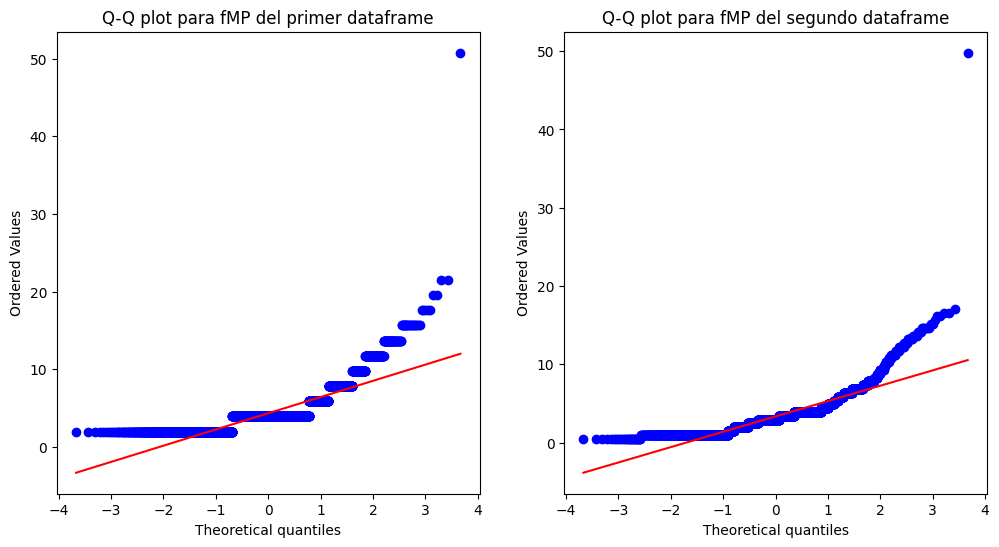

In [ ]:
# Histograma de cada conjunto de datos
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
sns.histplot(fmp1, kde=True)
plt.title('Distribución de fMP en el primer dataframe')

plt.subplot(1, 2, 2)
sns.histplot(fmp2, kde=True)
plt.title('Distribución de fMP en el segundo dataframe')
plt.show()

# Gráfico Q-Q para normalidad
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
stats.probplot(fmp1, dist="norm", plot=plt)
plt.title('Q-Q plot para fMP del primer dataframe')

plt.subplot(1, 2, 2)
stats.probplot(fmp2, dist="norm", plot=plt)
plt.title('Q-Q plot para fMP del segundo dataframe')
plt.show()


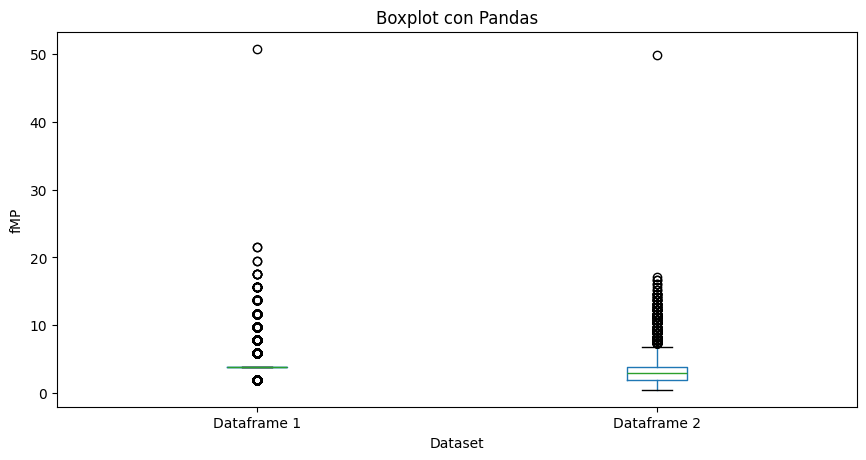

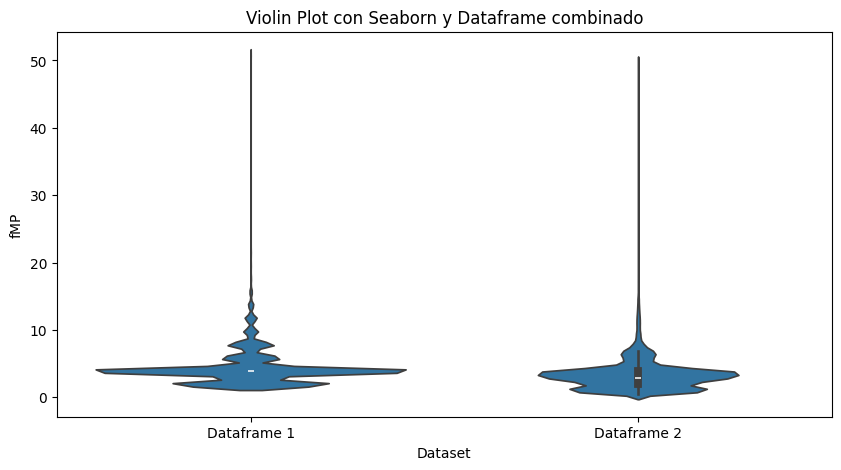

In [32]:
# Crear un dataframe combinado
df_combined = pd.DataFrame({
    'fMP': pd.concat([fmp1, fmp2]),
    'Dataset': ['Dataframe 1'] * len(fmp1) + ['Dataframe 2'] * len(fmp2)
})

# Boxplot con Pandas
df_combined.boxplot(by='Dataset', column='fMP', grid=False, figsize=(10, 5))
plt.title('Boxplot con Pandas')
plt.suptitle('')
plt.ylabel('fMP')
plt.show()

plt.figure(figsize=(10, 5))
sns.violinplot(data=df_combined, x='Dataset', y='fMP')
plt.title('Violin Plot con Seaborn y Dataframe combinado')
plt.show()


Ningunas de los datos obtenidos de las frecuencias siguen una distribución normal en los datos en ningun proyecto

Cómo podemos observar en la gráfica de distribución de los dataframes, concluimos que los datos no distribuyen normal, tienen una aglomeración en frecuencias menores a 20, característica de la electrocardiografia.

El gráfico Q-Q también es un indicador de la anormalidad de los datos, permitiendo concluir que como nuestros datos no se ubican en la línea recta de 45° no distribuyen de manera normal, ya que se presenta desviaciones de esta tendencia. En las distribución de los datos del proyecto 2 los valores se desvían en los extremos. En la distribución de las frecuencias del proyecto 3, en la mitad de los datos se presenta una alineación con una distribución normal, pero en los extremos no, esto se puede dar a datos atípicos de algunas frecuencias

# Referencias

[1] Zheng, J., Chu, H., Struppa, D., Zhang, J., Yacoub, M., El-Askary, H., Chang, A., Ehwerhemuepha, L., Abudayyeh, I., Barrett, A., Fu, G., Yao, H., Li, D., Guo, H., & Rakovski, C. (2020). Optimal Multi-Stage Arrhythmia Classification Approach. Scientific Reports, 10(1). https://doi.org/10.1038/s41598-020-59821-7

[2] Wang, Z., Zhu, J., Yan, T. y Yang, L. (2019). Un nuevo método de eliminación de ruido de ECG basado en wavelets modificado. Computer Assisted Surgery , 24 (sup1), 174–183. https://doi.org/10.1080/24699322.2018.1560088

[3] Pinto, E. ANEXO 1. Familias de Wavelets. Universidad Carlos III de Madrid

[4] González, J.R.. López, R.. Jaramillo, A. (2016). Las wavelets en el análisis de ECG. Universalidad Tecnológica de Pereira. Scientia Et Technica. Vol. 21, núm. 3, septiembre, 20217, pp. 273-277